In [28]:
import spacy
from spacy import Language
from collections import defaultdict
import operator
import math
from string import punctuation, ascii_letters, ascii_uppercase, ascii_lowercase
import random
from itertools import *
import numpy as np
import os
import matplotlib.pyplot as plt
#!python -m spacy info
#!pip install spacy==3.0.5
#!pip install spacy==3.0.3

In [11]:
global combs 
combs = []

def printAllKLength(set, k):
 
    n = len(set)
    printAllKLengthRec(set, "", n, k)
 
# The main recursive method
# to print all possible
# strings of length k
def printAllKLengthRec(set, prefix, n, k):
     
    # Base case: k is 0,
    # print prefix
    if (k == 0) :
        return prefix
 
    # One by one add all characters
    # from set and recursively
    # call for k equals to k-1
    for i in range(n):
 
        # Next character of input added
        newPrefix = prefix + set[i]
         
        # k is decreased, because
        # we have added a new character
        combs.append(printAllKLengthRec(set, newPrefix, n, k - 1))


In [172]:
def get_entities_for_text(model=None, text=""):
    doc = model(text)
    print("Entities in '%s'" % text)
    entities = {}
    for ent in doc.ents:
        entities[ent.text] = ent.label_
    return entities

def get_scores_per_entity(model=None, texts=[],):
    # Number of alternate analyses to consider. More is slower, and not necessarily better -- you need to experiment on your problem.
    beam_width = 3
    # This clips solutions at each step. We multiply the score of the top-ranked action by this value, and use the result as a threshold. This prevents the parser from exploring options that look very unlikely, saving a bit of efficiency. Accuracy may also improve, because we've trained on greedy objective.
    beam_density = 0.0001 

    ner = nlp.get_pipe('ner')
    docs = nlp.make_doc(texts[0])
    beams = ner.beam_parse([docs], beam_width=beam_width, beam_density=beam_density)
    #beams = ner.predict([docs])
    
    entity_scores = []
    for beam in beams:
        score_dict = defaultdict(float)
        for score, ents in ner.moves.get_beam_parses(beam):
            for start, end, label in ents:
                score_dict[(start, end, label)] += score
        entity_scores.append(score_dict)
    return entity_scores
    
    #return ner.scored_ents(beams)[0]

def get_scores_per_entity(model=None, texts=[], beam_width=3, r_space=0, secret_token_index=None, secret_index=None, secret=None, LABEL=None):
    """Get probability scores for entities for a list of texts."""
    
    nlp = model

    # Beam_width - Number of alternate analyses to consider. More is slower, and not necessarily better -- you need to experiment on your problem.
    # beam_density - This clips solutions at each step. We multiply the score of the top-ranked action by this value, and use the result as a threshold. This prevents the parser from exploring options that look very unlikely, saving a bit of efficiency. Accuracy may also improve, because we've trained on greedy objective.
    beam_density = 0.0001 

    score_per_combination = {}
    exposure_per_combination = {}

    ner = nlp.get_pipe('ner')

    for text in texts:
        doc = nlp.make_doc(text)
        beams = ner.beam_parse([doc], beam_width=beam_width, beam_density=0.0001)
        entity_scores = defaultdict(float)
        total_score = 0
        
        for score, ents in ner.moves.get_beam_parses(beams[0]):
            total_score += score
            for start, end, label in ents:
                entity_scores[(start, end, label)] += score
        if (secret_token_index,secret_token_index+1,LABEL) not in entity_scores:
            entity_scores[(secret_token_index,secret_token_index+1,LABEL)] = 0.0
        normalized_beam_score = {dict_key: dict_value/total_score for dict_key, dict_value in entity_scores.items()}
        score_per_combination[doc.text.split()[secret_index]] = normalized_beam_score[(secret_token_index,secret_token_index+1,LABEL)]
    #print(score_per_combination[secret])

    sorted_score_per_combination = dict(sorted(score_per_combination.items(), key=operator.itemgetter(1), reverse=True))
    rank = 1
    exposure_rank_secret = -1
    score_secret = -1
    exposure_secret = -1
    for code, score in sorted_score_per_combination.items():
        exposure = math.log2(r_space) - math.log2(rank)
        exposure_per_combination[code] = exposure
        if code == secret:
            exposure_rank_secret = rank
            score_secret = score
            exposure_secret = exposure
        rank += 1

    return score_per_combination, exposure_per_combination, exposure_rank_secret, score_secret, exposure_secret


In [12]:
def generate_password_given_prefix_suffix(prefix=None, suffix=None, length=None,  upper=True, lower=True, numeric=True, special=False):
    
    passwords = []
    if numeric and upper and lower:
        set1 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        set1.extend(set(ascii_lowercase))
        set1.extend(set(ascii_uppercase))
        printAllKLength(set1, length-4)
        res = [i for i in combs if i]
        for comb in res:
            password = prefix + comb + suffix
            passwords.append(password)
    if upper:
        pass
    if lower:
        pass
    if special:
        pass

    res.clear()
    combs.clear()
    return passwords


In [13]:
updated_nlp = spacy.load("models/20210406_spacy_3.0.5_with_password_abc123")

In [14]:
print('abc123' in updated_nlp.vocab.strings)
print('x002kn13039' in updated_nlp.vocab.strings)

True
False


In [21]:
secret = "abc123"
#secret = "x002kn13039"
text = "Rana's secret is {}".format(secret)
texts = [text]

length = len(secret)

nlp = spacy.load('en_core_web_lg')
print(spacy.__version__)
doc = nlp(text)
tokens = [str(token) for token in doc]
print(tokens)
secret_token_index = tokens.index(secret)
print(secret_token_index)
doc = nlp(text)
LABEL = "SECRET"

start_loc = 17
end_loc = start_loc+length

beam_width = 3

secret_index = doc.text.split().index(secret)
print(secret_index)

3.0.5
['Rana', "'s", 'secret', 'is', 'abc123']
4
3


In [22]:
print(get_entities_for_text(model=nlp, text=text))
#print(get_scores_per_entity(model=nlp, texts=[text]))

score, exposure, exposure_rank_secret, score_secret, exposure_secret = get_scores_per_entity(model=updated_nlp, texts=texts, beam_width=3, r_space=len(texts), secret_token_index=secret_token_index, secret_index=secret_index, secret=secret, LABEL=LABEL)

print(score_secret)

Entities in 'Rana's secret is abc123'
{'Rana': 'PERSON', 'abc123': 'PERSON'}
0.9708132609044945
0.9708132609044945


In [23]:
prefix = secret[0]
suffix = secret[-3:]

passwords = generate_password_given_prefix_suffix(prefix=prefix, suffix=suffix, length=len(secret),  upper=True, lower=True, numeric=True, special=False)

In [24]:
prefix = text[0:int(start_loc)]
suffix = text[int(end_loc):]
texts = []
for password in passwords:
    texts.append(prefix+password+suffix)

print("Extracting Whole Password")

score, exposure, exposure_rank_secret, score_secret, exposure_secret = get_scores_per_entity(model=updated_nlp, texts=texts, beam_width=3, r_space=len(texts), secret_token_index=secret_token_index, secret_index=secret_index, secret=secret, LABEL=LABEL)

Extracting Whole Password
0.9708132609044945


In [169]:
x = passwords

In [196]:
def h(x):
    prefix = text[0:int(start_loc)]
    suffix = text[int(end_loc):]
    texts = []
    texts.append(prefix+x+suffix)
    score, exposure, exposure_rank_secret, score_secret, exposure_secret = get_scores_per_entity(model=updated_nlp, texts=texts, beam_width=3, r_space=len(texts), secret_token_index=secret_token_index, secret_index=secret_index, secret=secret, LABEL=LABEL)
    return list(score.values())[0]

In [197]:
hv = np.vectorize(h)

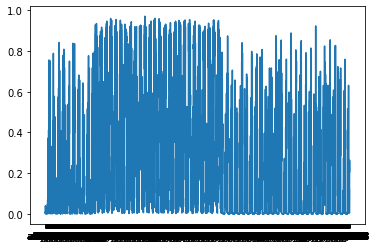

In [198]:
X = passwords
plt.plot(X, hv(X))

In [222]:
passwords[3844]

IndexError: list index out of range

In [238]:
def simple_greedy_search(func, start=0, N=100):
    x = start
    history = []
    for i in range(N):
        history.append(x)
        x_index = passwords.index(x)
        u = 1
        #u = 0.001
        if x_index == len(passwords)-1:
            xleft, xright = passwords[x_index-u], x
            yleft, yright = func(xleft), func(xright)
        elif x_index == 0:
            xleft, xright = x, passwords[x_index+u]
            yleft, yright = func(xleft), func(xright)
        else:
            xleft, xright = passwords[x_index-u], passwords[x_index+u]
            yleft, yright = func(xleft), func(xright)
        if yleft > yright:
            x = xleft
        else:
            x = xright
    return x, history

In [247]:
x0, history = simple_greedy_search(hv, start='abd123', N=100)

In [248]:
history[-1]

'abc123'

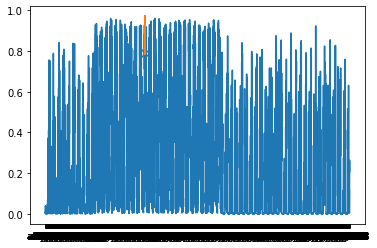

In [249]:
plt.plot(X, hv(X))
plt.scatter(x0, h(x0), marker='x', s=100)
plt.plot(history, hv(history))

In [233]:
def simulated_annealing(search_space, func, T):
    scale = np.sqrt(T)
    start = np.random.choice(search_space)
    x = start * 1
    cur = func(x)
    history = [x]
    for i in range(1000):
        prop = x + np.random.normal()*scale
        if prop > 1 or prop < 0 or np.log(np.random.rand()) * T > (func(prop) - cur):
            prop = x
        x = prop
        cur = func(x)
        T = 0.9 * T
        history.append(x)
    return x, history

In [234]:
X = passwords
x1, history = simulated_annealing(X, h, T=4)

plt.plot(X, hv(X))
plt.scatter(x1, hv(x1), marker = 'x')
plt.plot(history, hv(history))

TypeError: must be str, not numpy.float64

# SIMULATED ANNEALING

In [143]:
import numpy as np
import matplotlib.pyplot as plt

In [158]:
def h(x):
    if x < -1 or x > 1:
        y = 0
    else:
        y = (np.cos(50*x) + np.sin(20*x))
    return y

hv = np.vectorize(h)

#hv = np.vectorize(np.array(score.values()))

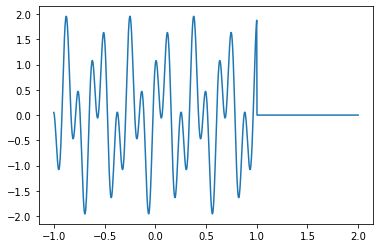

In [131]:
X = np.linspace(-1, 2, num = 1000)
plt.plot(X, hv(X))

In [132]:
def simple_greedy_search(func, start=0, N=100):
    x = start
    history = []
    for i in range(N):
        history.append(x)
        u= 0.001
        xleft, xright = x-u, x+u
        yleft, yright = func(xleft), func(xright)
        if yleft > yright:
            x = xleft
        else:
            x = xright
    return x, history

In [133]:
x0, history = simple_greedy_search(hv, start=-0.02, N=100)

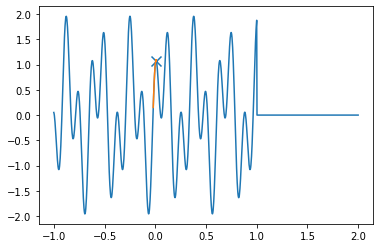

In [134]:
plt.plot(X, hv(X))
plt.scatter(x0, h(x0), marker='x', s=100)
plt.plot(history, hv(history))

In [135]:
def simulated_annealing(search_space, func, T):
    scale = np.sqrt(T)
    start = np.random.choice(search_space)
    x = start * 1
    cur = func(x)
    history = [x]
    for i in range(1000):
        prop = x + np.random.normal()*scale
        if prop > 1 or prop < 0 or np.log(np.random.rand()) * T > (func(prop) - cur):
            prop = x
        x = prop
        cur = func(x)
        T = 0.9 * T
        history.append(x)
    return x, history

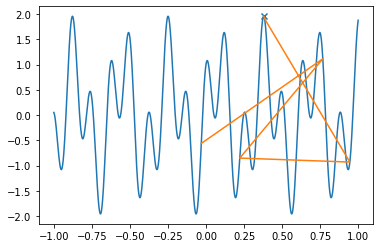

In [138]:
X = np.linspace(-1, 1, num=1000)
x1, history = simulated_annealing(X, h, T=4)

plt.plot(X, hv(X))
plt.scatter(x1, hv(x1), marker = 'x')
plt.plot(history, hv(history))